# Data Preparation
-----

### Constants and Folder Paths

In [2]:
dataset_folder_path = 'temp'
NUM_SAMPLES = 200

### Load Data

In [3]:
from data.DataSet import DataSet
dataset = DataSet(dataset_folder_path)

### Data Preprocessing

In [4]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
#dataset.apply(partial(normalize_pressure_value, max_pressure_val=512))
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand(reverse_digit_sequence)
# dataset.apply(lambda digit: convert_xy_to_derivative(digit, normalize=False))
#dataset.apply(partial(convert_xy_to_derivative, normalize=True))

### Split Dataset into *Train*, *Valid*, and *Test*

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_valid = np.array(dataset.train_data)
X_test = np.array(dataset.test_data)
# Convert labels to numpy array and OneHot encode them
encoder, train_valid_labels, Y_test = dataset.get_labels_as_numpy(onehot=True)
train_valid_labels = train_valid_labels.astype('float32').todense()
Y_test = Y_test.astype('float32').todense()
# Split Data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, train_valid_labels, shuffle=True, stratify=train_valid_labels, random_state=42)

# Neural Network Setup and Training
----------

### Parameters

In [6]:
PARAM_NUM_EPOCHS = 30
PARAM_BATCH_SIZE = 300

### Setup Model

In [7]:
from models.naive_gru import NaiveGRU

mymodel = NaiveGRU(X_train.shape[1:])
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)

Using TensorFlow backend.




----------

Optimizer: <class 'keras.optimizers.Adam'>
Batch Size: 300
Number of Epochs: 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 200, 256)          198912    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 595,466
Trainable params: 595,466
Non-trainable params: 0
_________________________________________________________________


----------




#### Save Model Summary

In [8]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [9]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 3600 samples, validate on 1200 samples
Epoch 1/30
3600/3600 [==============================] - 4s 1ms/step - loss: 2.1844 - categorical_accuracy: 0.2111 - val_loss: 2.1237 - val_categorical_accuracy: 0.2333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23333, saving model to checkpoints/1523392821.1466396/naive_overfit_gru-01-0.23.hdf5
Epoch 2/30
3600/3600 [==============================] - 4s 1ms/step - loss: 2.1154 - categorical_accuracy: 0.2353 - val_loss: 2.0930 - val_categorical_accuracy: 0.2417

Epoch 00002: val_categorical_accuracy improved from 0.23333 to 0.24167, saving model to checkpoints/1523392821.1466396/naive_overfit_gru-02-0.24.hdf5
Epoch 3/30
3600/3600 [==============================] - 4s 1ms/step - loss: 2.0554 - categorical_accuracy: 0.2403 - val_loss: 1.9677 - val_categorical_accuracy: 0.2758

Epoch 00003: val_categorical_accuracy improved from 0.24167 to 0.27583, saving model to checkpoints/1523392821.1466396/naive_overfit_gru-03-0.28.hdf

### Evaluate Model

##### Increase default plotsize for matplotlib

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Test Set Accuracy

In [10]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

2400/2400 [==============================] - 4s 2ms/step
Test Loss: 0.353, Test Acc: 91.708%


#### Recall, Precision, F1_Score on Validation set

In [11]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf

1200/1200 [==============================] - 2s 2ms/step


,recall,precision,f1 score,#
0,0.974359,0.950000,0.962025,120.0
1,0.897638,0.950000,0.923077,120.0
2,0.920635,0.966667,0.943089,120.0
3,0.983051,0.966667,0.974790,120.0
4,0.973684,0.925000,0.948718,120.0
5,0.868852,0.883333,0.876033,120.0
6,0.934959,0.958333,0.946502,120.0
7,0.916667,0.916667,0.916667,120.0
8,0.964912,0.916667,0.940171,120.0
9,0.941176,0.933333,0.937238,120.0


In [12]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf

2400/2400 [==============================] - 4s 2ms/step


,recall,precision,f1 score,#
0,0.904580,0.987500,0.944223,240.0
1,0.919028,0.945833,0.932238,240.0
2,0.917355,0.925000,0.921162,240.0
3,0.945378,0.937500,0.941423,240.0
4,0.860000,0.895833,0.877551,240.0
5,0.939914,0.912500,0.926004,240.0
6,0.958678,0.966667,0.962656,240.0
7,0.867704,0.929167,0.897384,240.0
8,0.960177,0.904167,0.931330,240.0
9,0.906404,0.766667,0.830700,240.0


#### Plot Confusion Matrix

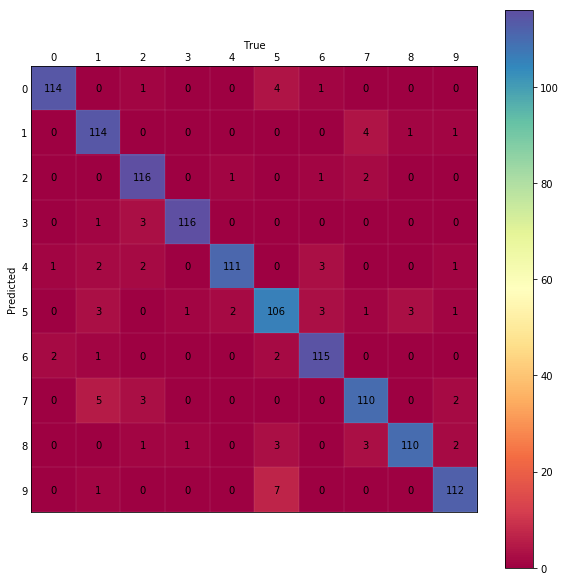

In [16]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

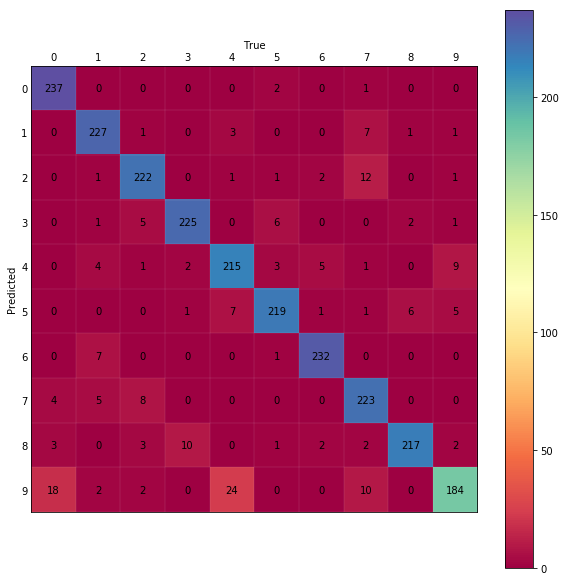

In [17]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from keras.models import load_model
mymodel.model = load_model("checkpoints/1523369406.7123575/naive_overfit_gru-30-0.97.hdf5")